
### T1 Data Analysis  

        Sean Keenan, PhD Physics  
        Quantum Memories Group, Heriot-Watt University, Edinburgh  
        2021  

In [1]:
import os
import spec_funcs as sf
import fit_funcs as ff
from filter_funcs import moving_av
from scipy.signal import fftconvolve
import numpy as np
import matplotlib.pyplot as mp

mp.style.use('signature.mplstyle')

path = r"C:\Users\sk88\Desktop\Fluor_duration46"


##### Import Data  
        
        Load data sets & extract time and voltage data


In [2]:
_, file_names = sf.dir_interogate(path)
file_paths = [os.path.join(path, f_name) for f_name in file_names]
data_lists = [sf.open_excel(file_path) for file_path in file_paths]
length_data_lists = range(len(data_lists))
time_lists = [data_lists[n][0] for n in length_data_lists]
trigger_lists = [data_lists[n][1] for n in length_data_lists]
reference_lists = [data_lists[n][3] for n in length_data_lists]
transmitted_lists = [data_lists[n][2] for n in length_data_lists]


##### Check channel assignment  

        Plot one of each channel to check assignment is correct for calculations


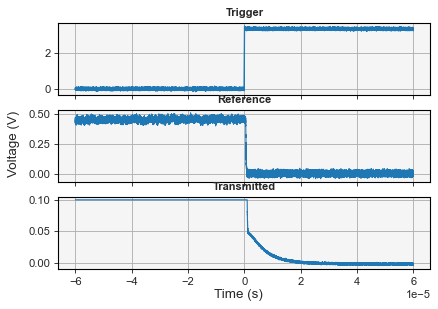

In [3]:
fig, ax = mp.subplots(nrows=3, ncols=1, sharex='all')
fig.supxlabel('Time (s)')
fig.supylabel('Voltage (V)')

ax[0].set_title('Trigger')
ax[0].plot(time_lists[0], trigger_lists[0])
ax[1].set_title('Reference')
ax[1].plot(time_lists[0], reference_lists[0])
ax[2].set_title('Transmitted')
ax[2].plot(time_lists[0], transmitted_lists[0])


##### Fine Tune Trigger Point

        Check the trigger index and adjust if neccesary
        

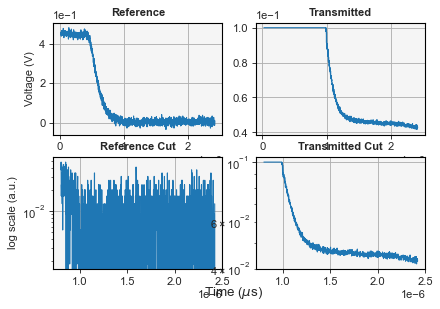

In [4]:
# find the trigger indexes
trig_indexes = [sf.find_trigger(trigger_list, modifier=0.989) for trigger_list in trigger_lists]
# plot small portion to check ramp off on transmitted data
ramp_off = 2000 + trig_indexes[0]
# pick an offset
offset = 650
# plot the transmitted data from trigger point and compare with the offset 
fig, ax = mp.subplots(ncols=2, nrows=2)
# shared labels
fig.supxlabel('Time ($\mu$s)')
# plot on separate subplots
ax[0][0].set_title('Reference')
ax[0][0].plot(time_lists[0][trig_indexes[0]:ramp_off], reference_lists[0][trig_indexes[0]:ramp_off])
ax[0][0].ticklabel_format(axis='both', style='sci', scilimits=(0,0))
ax[0][0].set(ylabel='Voltage (V)')
ax[0][1].set_title('Transmitted')
ax[0][1].plot(time_lists[0][trig_indexes[0]:ramp_off], transmitted_lists[0][trig_indexes[0]:ramp_off])
ax[0][1].ticklabel_format(axis='both', style='sci', scilimits=(0,0))
ax[1][0].set_title('Reference Cut')
ax[1][0].plot(time_lists[0][trig_indexes[0]+offset:ramp_off], reference_lists[0][trig_indexes[0]+offset:ramp_off])
ax[1][0].ticklabel_format(axis='both', style='sci', scilimits=(0,0))
ax[1][0].set(ylabel='log scale (a.u.)')
ax[1][0].set_yscale('log')
ax[1][1].set_title('Transmitted Cut')
ax[1][1].plot(time_lists[0][trig_indexes[0]+offset:ramp_off], transmitted_lists[0][trig_indexes[0]+offset:ramp_off])
ax[1][1].ticklabel_format(axis='both', style='sci', scilimits=(0,0))
ax[1][1].set_yscale('log')


##### Process Data  

        Remove negatives and create smoothed and normalised sets


In [5]:
# initial guess for the decay times (us)
guess_ref_T1 = 1E-6
guess_T1 = 20E-6
# shorten data for fitting by finding last index of useful data
ref_stop_index = [round(guess_ref_T1*10 / (time[1] - time[0])) for time in time_lists]
stop_index = [round(guess_T1*4  / (time[1] - time[0])) for time in time_lists]
# generate new list of trigger indexes plus the offset
new_trig_index = [value + offset for value in trig_indexes]
# trim the data sets to only contain data from the trigger onward to the end of useful data index
time_cut_lists = [time_list[start:start+stop] for time_list, start, stop in zip(time_lists, new_trig_index, stop_index)]
ref_time_lists = [time_list[start:start+stop] for time_list, start, stop in zip(time_lists, new_trig_index, ref_stop_index)]
trans_cut_lists = [trans_list[start:start+stop] for trans_list, start, stop in zip(transmitted_lists, new_trig_index, stop_index)]
ref_cut_lists = [ref_list[start:start+stop] for ref_list, start, stop in zip(reference_lists, new_trig_index, ref_stop_index)]
# find max and min values in transmitted data for list comprehension
list_of_mins = [min(trans_list) for trans_list in transmitted_lists]
list_of_maxs = [max(trans_list) for trans_list in trans_cut_lists]
ref_min_list = [min(ref_list) for ref_list in reference_lists]
ref_max_list = [max(ref_list) for ref_list in ref_cut_lists]
# create a boxcar window and then create a list of smoothed data
avg_window = moving_av(50)
length_avg_window = avg_window.shape[0] // 2
# create lists of smoothed, corrected, smoothed and corrected
ref_corrected = [[value - ref_min for value in ref_list] for ref_list, ref_min in zip(ref_cut_lists, ref_min_list)]
trans_smoothed = [fftconvolve(avg_window, trans_cut_list)[length_avg_window-1:-length_avg_window] for trans_cut_list in trans_cut_lists]
trans_corrected = [[value - trans_min for value in trans_list] for trans_list, trans_min in zip(trans_cut_lists,list_of_mins)]
trans_avg_cor = [[value - trans_min for value in smoothed_list] for smoothed_list, trans_min in zip(trans_smoothed, list_of_mins)]


##### Fit to Reference Detector Data
        Determine Fall Time

Fit Params data[0]:
I0 : 445387536.60 mV, T1 : 0.08 us, Y0 : 42662.73 mV
Fit Error data[0]:
dI0 : 532238161.50 mV, dT1 : 0.01 us, dY0 : 120.18 mV 

Fit Params data[1]:
I0 : 188455823.80 mV, T1 : 0.09 us, Y0 : 44280.26 mV
Fit Error data[1]:
dI0 : 229347118.46 mV, dT1 : 0.01 us, dY0 : 120.70 mV 

Fit Params data[2]:
I0 : 5154954604.33 mV, T1 : 0.07 us, Y0 : 43523.39 mV
Fit Error data[2]:
dI0 : 7564879435.30 mV, dT1 : 0.01 us, dY0 : 120.34 mV 

Fit Params data[3]:
I0 : 1593707069.77 mV, T1 : 0.07 us, Y0 : 47112.63 mV
Fit Error data[3]:
dI0 : 2548862344.43 mV, dT1 : 0.01 us, dY0 : 119.16 mV 

Fit Params data[4]:
I0 : 1044940108.40 mV, T1 : 0.08 us, Y0 : 43793.97 mV
Fit Error data[4]:
dI0 : 1696561304.11 mV, dT1 : 0.01 us, dY0 : 120.63 mV 

Fit Params data[5]:
I0 : 6530096401.55 mV, T1 : 0.07 us, Y0 : 48211.75 mV
Fit Error data[5]:
dI0 : 10400664662.62 mV, dT1 : 0.01 us, dY0 : 119.86 mV 

Fit Params data[6]:
I0 : 392679717.29 mV, T1 : 0.08 us, Y0 : 40127.31 mV
Fit Error data[6]:
dI0 : 52692

C:\Users\sk88\AppData\Local\Temp\ipykernel_27476\1303128340.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = mp.subplots(nrows=1, ncols=2)


Fit Params data[22]:
I0 : 232556073.87 mV, T1 : 0.09 us, Y0 : 50794.24 mV
Fit Error data[22]:
dI0 : 244247444.98 mV, dT1 : 0.01 us, dY0 : 122.21 mV 

Fit Params data[23]:
I0 : 679902202.02 mV, T1 : 0.08 us, Y0 : 44074.92 mV
Fit Error data[23]:
dI0 : 1032054410.85 mV, dT1 : 0.01 us, dY0 : 120.20 mV 

Fit Params data[24]:
I0 : 513642267.19 mV, T1 : 0.08 us, Y0 : 43659.91 mV
Fit Error data[24]:
dI0 : 662396402.50 mV, dT1 : 0.01 us, dY0 : 119.89 mV 



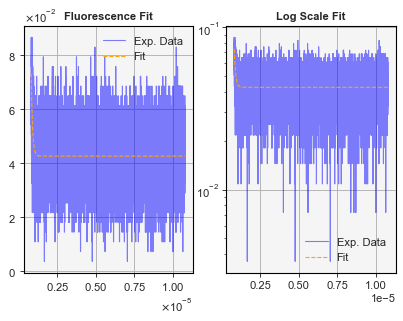

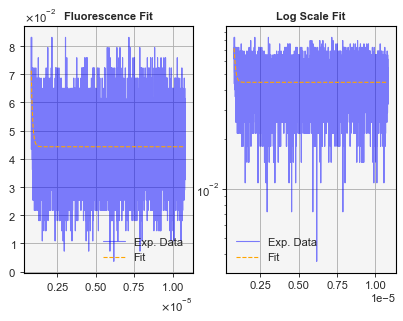

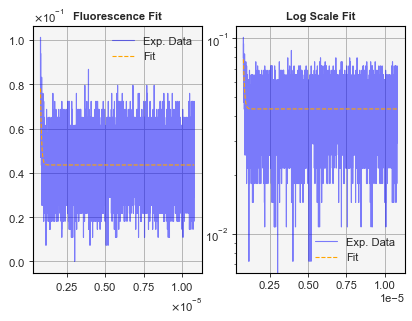

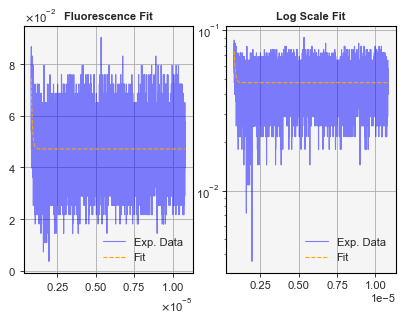

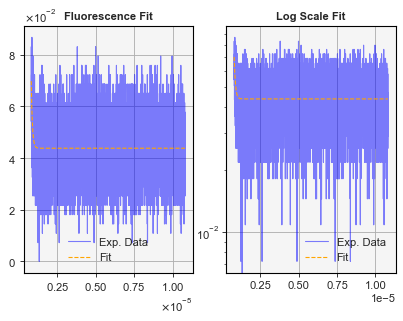

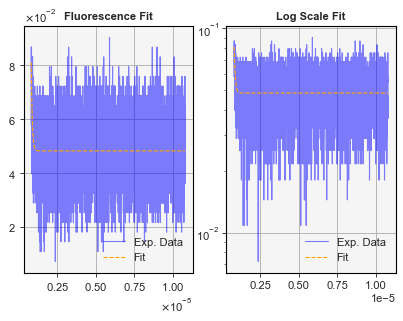

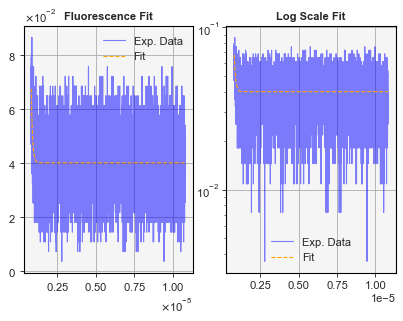

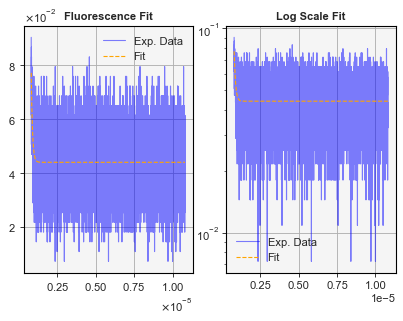

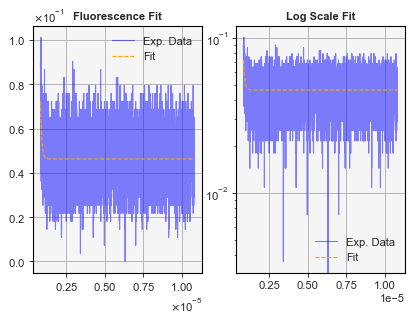

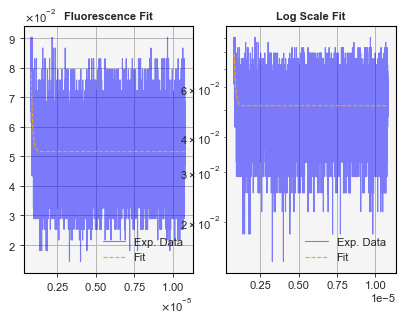

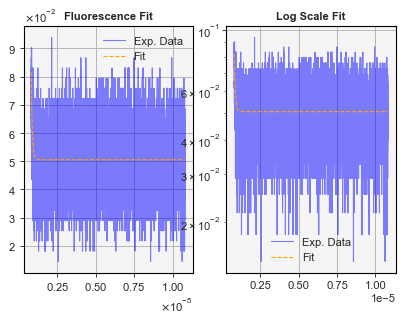

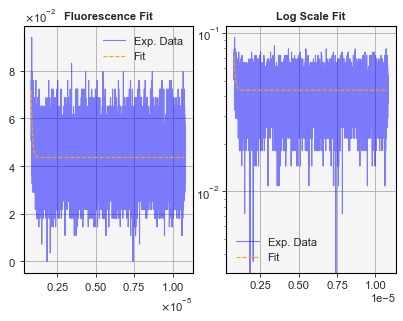

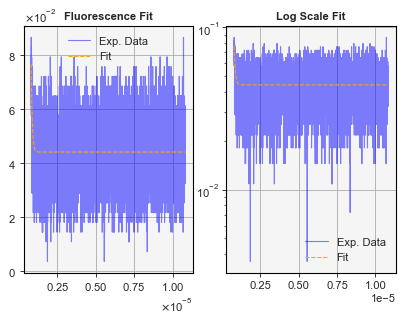

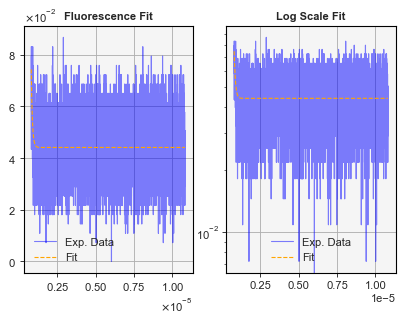

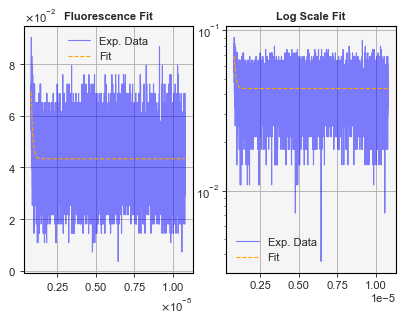

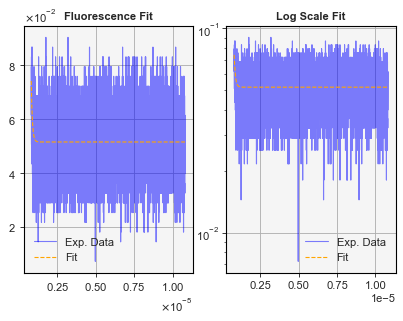

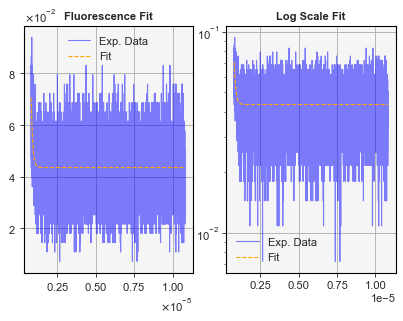

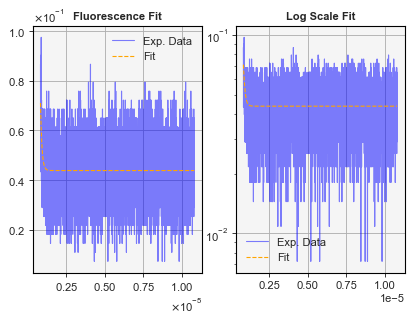

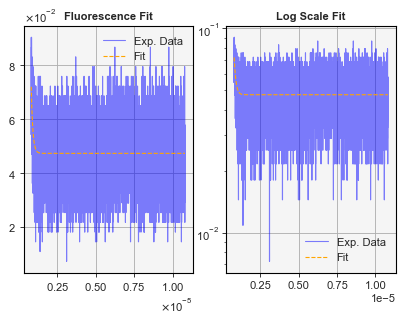

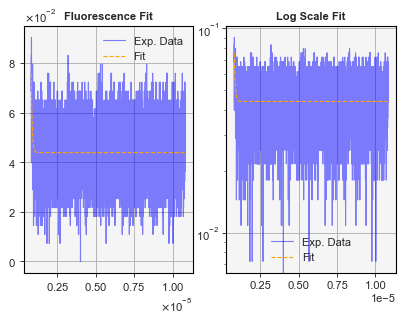

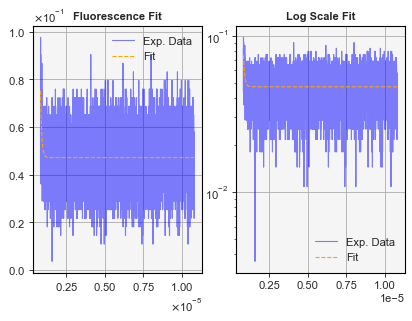

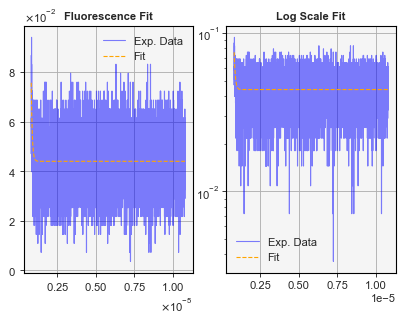

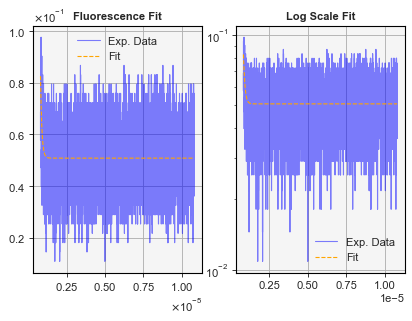

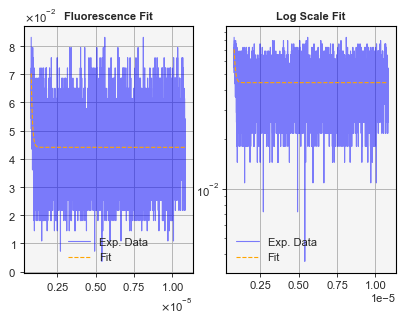

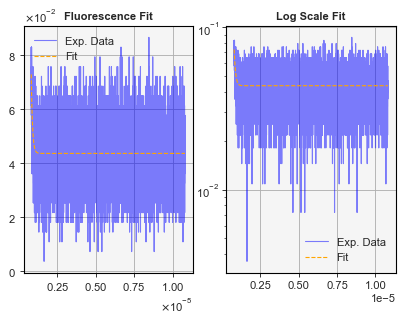

In [6]:
ref_zipped = zip(ref_time_lists, ref_corrected, ref_max_list, ref_min_list)
fit_ref_corrected = [ff.fit_exp_decay(time, ref, params=(max_value, guess_ref_T1, min_value)) for time, ref, max_value, min_value in ref_zipped]
# loop over references - fit and plot data
for idx, time in enumerate(ref_time_lists):
    # zip data together for list comprehension

    fig, ax = mp.subplots(nrows=1, ncols=2)
    
    ax[0].set_title('Fluorescence Fit')
    ax[0].plot(time, ref_corrected[idx], color='blue', alpha=0.5, label='Exp. Data')
    ax[0].plot(time, ff.exp_decay(np.array(time), *fit_ref_corrected[idx][0]), color='orange', linestyle='--', alpha=1, label='Fit')
    ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText = True)
    ax[0].legend()
    ax[1].set_title('Log Scale Fit')
    ax[1].plot(time, ref_corrected[idx], color='blue', alpha=0.5, label='Exp. Data')
    ax[1].plot(time, ff.exp_decay(np.array(time), *fit_ref_corrected[idx][0]), color='orange', linestyle='--', alpha=1, label='Fit')
    ax[1].set_yscale('log')
    ax[1].legend()
    print('Fit Params data[{0}]:'.format(idx))
    print("I0 : {0:2.2f} mV, T1 : {1:2.2f} us, Y0 : {2:2.2f} mV".format(*fit_ref_corrected[idx][0]*1E6))
    print('Fit Error data[{0}]:'.format(idx))
    print("dI0 : {0:2.2f} mV, dT1 : {1:2.2f} us, dY0 : {2:2.2f} mV \n".format(*fit_ref_corrected[idx][1]*1E6))

ref_fall_times = [T1[1][0] for T1 in fit_ref_corrected]


##### Fit To Corrected Data

        Fit to double exponential decay and return array of fit params and errors
      

c:\Users\sk88\Documents\Python\Spectroscopy\.spect_venv\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\sk88\Documents\Python\Spectroscopy\fit_funcs.py:32: RuntimeWarning: overflow encountered in exp
  return (y_1 * np.exp(-x/T1)) + (y_2 * np.exp(-x/T2)) + offset


0
Fit Params data[0]:
I01 : 76123.38 mV, I02 : 682210.32 mV, T11 : 5.60 us, T12 : -1103608595022469.00 us, Y0 : -679270.88 mV
Fit Error data[0]:
dI01 : inf mV, dI02 : inf mV, dT11 : inf us, dT12 : inf us, dY0 : inf mV 

1
Fit Params data[1]:
I01 : 74754.98 mV, I02 : 116705.41 mV, T11 : 5.65 us, T12 : 195711918275118.28 us, Y0 : -113808.25 mV
Fit Error data[1]:
dI01 : inf mV, dI02 : inf mV, dT11 : inf us, dT12 : inf us, dY0 : inf mV 

2
Fit Params data[2]:
I01 : 77842.24 mV, I02 : 27618.95 mV, T11 : 5.54 us, T12 : -25385239328505236.00 us, Y0 : -24838.85 mV
Fit Error data[2]:
dI01 : inf mV, dI02 : inf mV, dT11 : inf us, dT12 : inf us, dY0 : inf mV 

3
Fit Params data[3]:
I01 : 77923.64 mV, I02 : 21314.65 mV, T11 : 5.61 us, T12 : -6962304750291538.00 us, Y0 : -18066.30 mV
Fit Error data[3]:
dI01 : inf mV, dI02 : inf mV, dT11 : inf us, dT12 : inf us, dY0 : inf mV 

4
Fit Params data[4]:
I01 : 76733.59 mV, I02 : -77539.63 mV, T11 : 5.59 us, T12 : -3386130111129186.00 us, Y0 : 80252.14 mV
F

C:\Users\sk88\AppData\Local\Temp\ipykernel_27476\3474840908.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = mp.subplots(nrows=1, ncols=2)


Fit Params data[23]:
I01 : 74876.21 mV, I02 : 18234.28 mV, T11 : 5.60 us, T12 : -1350424157051378.25 us, Y0 : -15321.80 mV
Fit Error data[23]:
dI01 : inf mV, dI02 : inf mV, dT11 : inf us, dT12 : inf us, dY0 : inf mV 

24
Fit Params data[24]:
I01 : 75515.73 mV, I02 : 186358.69 mV, T11 : 5.57 us, T12 : -556621801239337.44 us, Y0 : -183628.95 mV
Fit Error data[24]:
dI01 : inf mV, dI02 : inf mV, dT11 : inf us, dT12 : inf us, dY0 : inf mV 



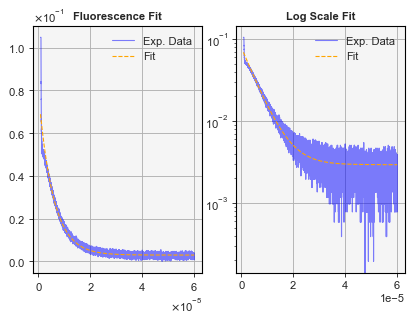

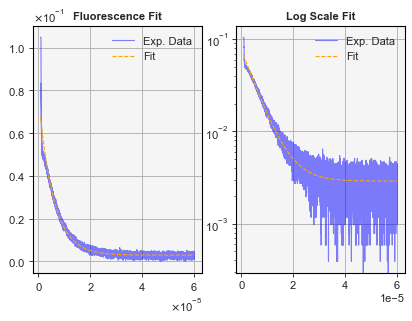

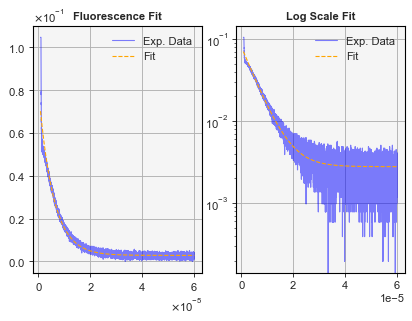

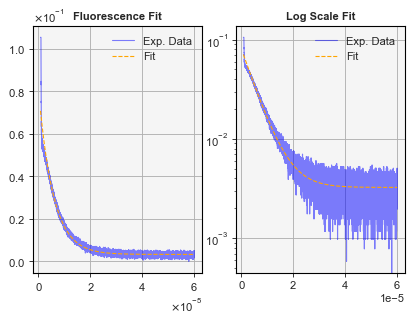

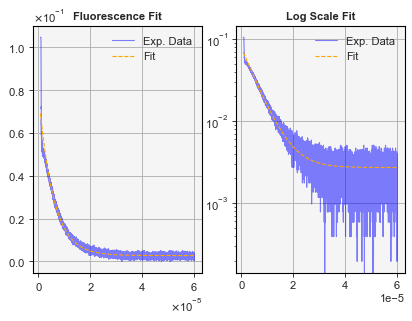

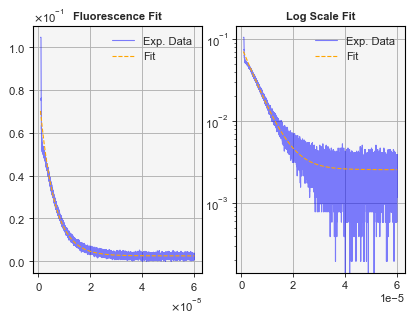

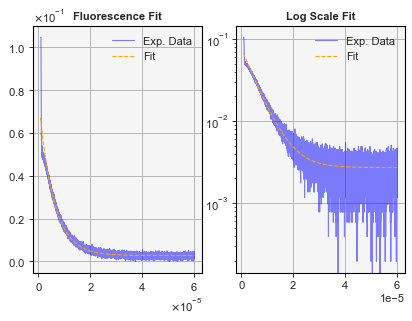

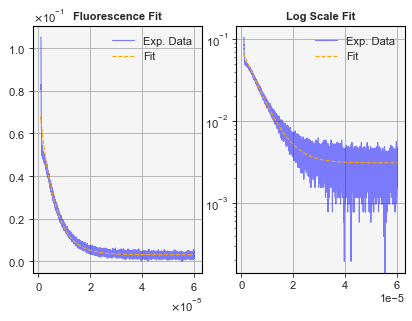

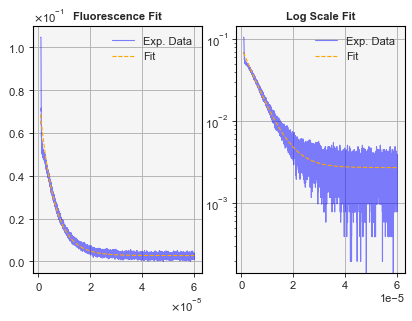

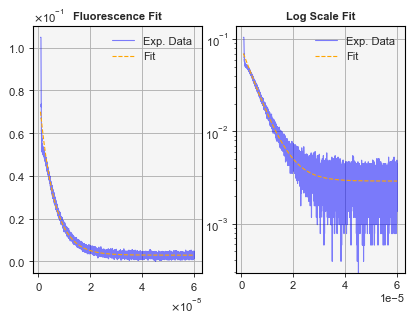

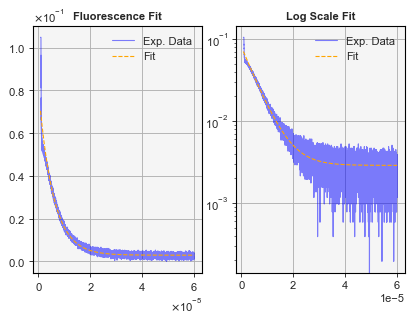

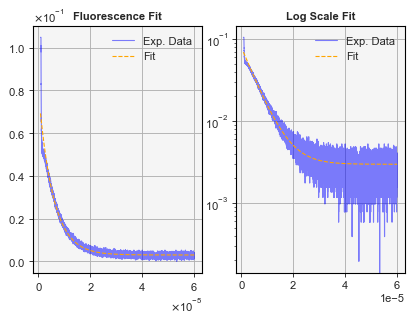

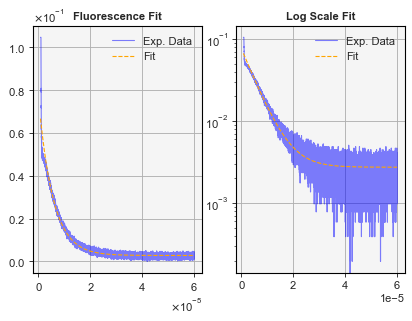

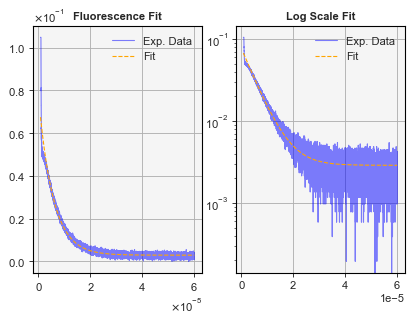

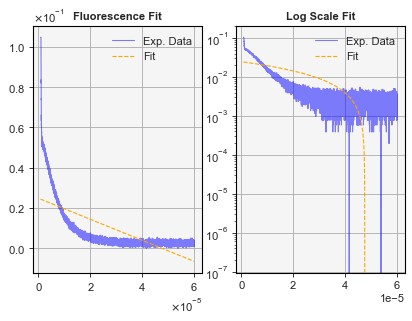

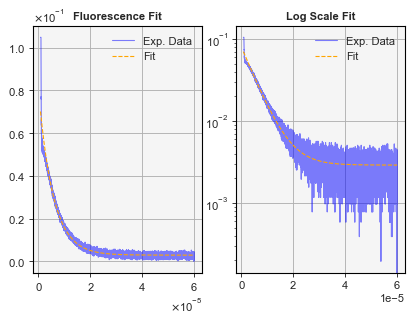

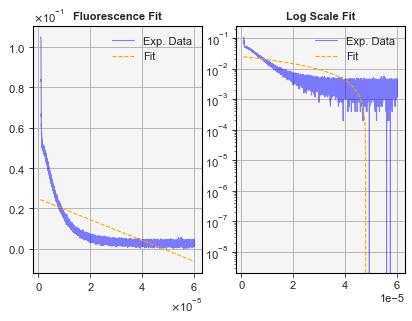

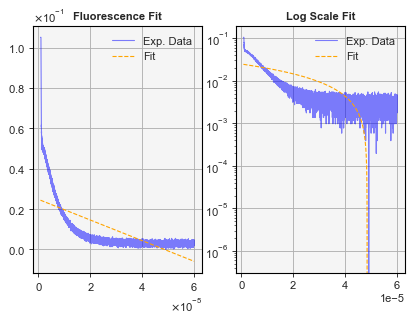

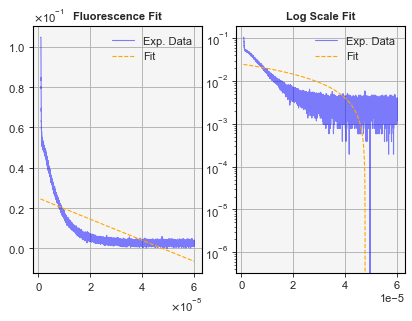

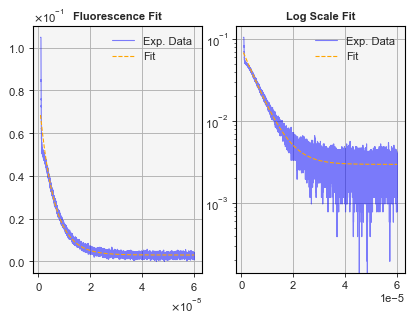

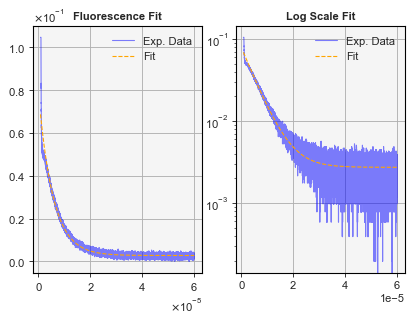

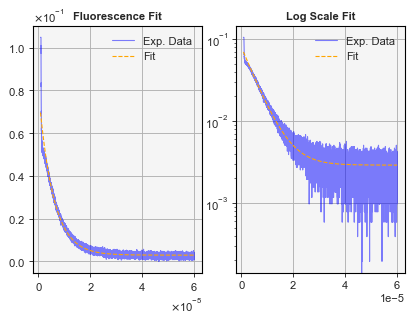

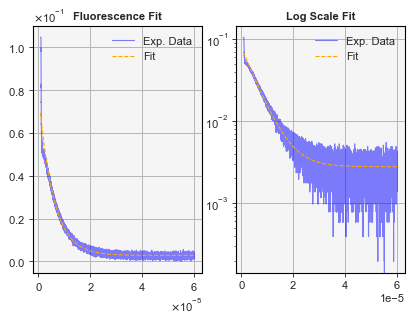

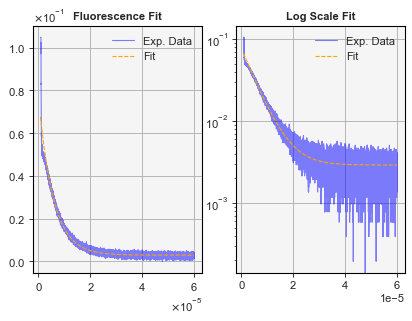

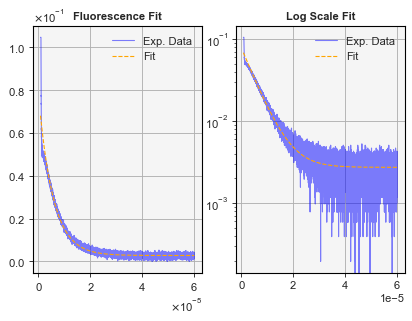

In [7]:
# zip data together for list comprehension
zipped_data = zip(time_cut_lists, trans_corrected, list_of_maxs, ref_max_list, list_of_mins, ref_fall_times)
fit_corrected = [ff.fit_dbl_exp_decay(time, trans, params=(0.3*max_val, ref_max, guess_T1, fall_time, min_val)) for time, trans, max_val, ref_max, min_val, fall_time in zipped_data]
# loop over corrected transmitted data - fit and plot data
for idx, time in enumerate(time_cut_lists):
    print(idx)

    fig, ax = mp.subplots(nrows=1, ncols=2)
    
    ax[0].set_title('Fluorescence Fit')
    ax[0].plot(time, trans_corrected[idx], color='blue', alpha=0.5, label='Exp. Data')
    ax[0].plot(time, ff.dbl_exp_decay(np.array(time), *fit_corrected[idx][0]), color='orange', linestyle='--', alpha=1, label='Fit')
    ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText = True)
    ax[0].legend()
    
    ax[1].set_title('Log Scale Fit')
    ax[1].plot(time, trans_corrected[idx], color='blue', alpha=0.5, label='Exp. Data')
    ax[1].plot(time, ff.dbl_exp_decay(np.array(time), *fit_corrected[idx][0]), color='orange', linestyle='--', alpha=1, label='Fit')
    ax[1].set_yscale('log')
    ax[1].legend()
    print('Fit Params data[{0}]:'.format(idx))
    print("I01 : {0:2.2f} mV, I02 : {1:2.2f} mV, T11 : {2:2.2f} us, T12 : {3:2.2f} us, Y0 : {4:2.2f} mV".format(*fit_corrected[idx][0]*1E6))
    print('Fit Error data[{0}]:'.format(idx))
    print("dI01 : {0:2.2f} mV, dI02 : {1:2.2f} mV, dT11 : {2:2.2f} us, dT12 : {3:2.2f} us, dY0 : {4:2.2f} mV \n".format(*fit_corrected[idx][1]*1E6))

In [8]:
fit_calc = []